In [7]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 1. Load the data, parse dates, and create a year column
df = pd.read_csv("D:/DATA FOR RESEARCH PROJECT/Clean data/pacemakerClean2.csv",
                 parse_dates=["DATE_RECEIVED_x"],  # adjust column name if different
                 low_memory=False)
df["year"] = df["DATE_RECEIVED_x"].dt.year

# 2. Basic inspection
print(df.info())                # dtypes, null counts
print(df.describe(include="all"))  # summary statistics (numeric + object)

# 3. Descriptive statistics
# 3a. Numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(df[numeric_cols].describe())

# 3b. Categorical columns of interest
for col in ["GENERIC_NAME", "MANUFACTURER_D_NAME", "ADVERSE_EVENT_FLAG"]:
    print(f"\nValue counts for {col}:")
    print(df[col].value_counts(dropna=False))

# 4. Temporal trend: adverse‑event rate by year
yearly = (
    df.groupby("year")["ADVERSE_EVENT_FLAG"]
      .mean()
      .reset_index(name="event_rate")
)
print("\nYearly adverse event rates:")
print(yearly)

# 5. Association test: manufacturer vs. adverse‑event flag
contingency = pd.crosstab(df["MANUFACTURER_D_NAME"], df["ADVERSE_EVENT_FLAG"])
chi2, p, dof, exp = stats.chi2_contingency(contingency)
print(f"\nChi‑square test for manufacturer vs. adverse flag:")
print(f"  χ² = {chi2:.2f}, p‑value = {p:.3f}, dof = {dof}")

# 6. Correlation matrix (numeric variables only)
corr = df[numeric_cols].corr()
print("\nCorrelation matrix:")
print(corr)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282572 entries, 0 to 282571
Data columns (total 78 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   MDR_REPORT_KEY                  282572 non-null  int64         
 1   DATE_RECEIVED_x                 282572 non-null  datetime64[ns]
 2   BRAND_NAME                      281075 non-null  object        
 3   GENERIC_NAME                    282572 non-null  object        
 4   MANUFACTURER_D_NAME             282454 non-null  object        
 5   MANUFACTURER_D_ADDRESS_1        268972 non-null  object        
 6   MANUFACTURER_D_CITY             269059 non-null  object        
 7   MANUFACTURER_D_STATE_CODE       242034 non-null  object        
 8   MANUFACTURER_D_ZIP_CODE         261793 non-null  object        
 9   MANUFACTURER_D_COUNTRY_CODE     266398 non-null  object        
 10  MANUFACTURER_D_POSTAL_CODE      261793 non-null  object 

Missing ADVERSE_EVENT_FLAG: 365
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.69      0.57      0.62     17928
           1       0.62      0.73      0.67     17055

    accuracy                           0.65     34983
   macro avg       0.65      0.65      0.64     34983
weighted avg       0.65      0.65      0.64     34983

=== Confusion Matrix ===
[[10201  7727]
 [ 4676 12379]]
ROC AUC: 0.721


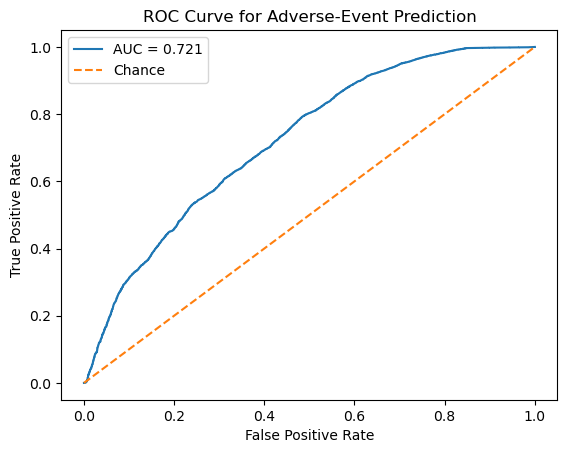


Feature coefficients (log‑odds):
  MDR_REPORT_KEY       → -0.166
  MDR_TEXT_KEY         → 0.039
  REPORTER_OCCUPATION_CODE → -0.505
  MANUFACTURER_CONTACT_ZIP_CODE → 0.469
  MANUFACTURER_CONTACT_POSTAL → 0.012
  MANUFACTURER_CONTACT_AREA_CODE → -0.885
  MANUFACTURER_CONTACT_EXCHANGE → -0.885
  MANUFACTURER_CONTACT_PHONE_NO → 1.062
  NOE_SUMMARIZED       → -0.018
  year                 → 0.019


In [16]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    roc_curve,
    confusion_matrix
)

# 1. Check how many missing flags you have
n_missing = df["ADVERSE_EVENT_FLAG"].isna().sum()
print(f"Missing ADVERSE_EVENT_FLAG: {n_missing}")

# 2. Drop rows where the flag is missing
df = df[df["ADVERSE_EVENT_FLAG"].notna()].copy()

# 3. Now safely convert the flag to integer
df["ADVERSE_EVENT_FLAG"] = df["ADVERSE_EVENT_FLAG"].astype(int)

# 4. Re‑define your X and y
features = [c for c in numeric_cols if c != "ADVERSE_EVENT_FLAG"]
X = df[features].copy()
y = df["ADVERSE_EVENT_FLAG"]

# 5. (Optional) Drop any remaining rows with missing predictor values
mask = X.notna().all(axis=1)
X = X[mask]
y = y[mask]


# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Scale predictors
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Fit the logistic‐regression model
model = LogisticRegression(max_iter=1000, solver="liblinear")
model.fit(X_train_scaled, y_train)

# Evaluate on the test set
y_pred  = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:,1]

print("=== Classification Report ===")
print(classification_report(y_test, y_pred))

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC: {auc:.3f}")

# Plot the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], "--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Adverse‑Event Prediction")
plt.legend()
plt.show()

# Inspect learned coefficients
print("\nFeature coefficients (log‑odds):")
for feat, coef in zip(features, model.coef_[0]):
    print(f"  {feat:20s} → {coef:.3f}")
